# Saliency Analysis for Pneumonia Detection Model

This notebook performs **perturbation-based saliency analysis** to visualize which parts of chest X-ray images are most important for the model's predictions.

## What is Perturbation-Based Saliency?

The idea is simple:
1. Take an X-ray image
2. Cover up small patches one at a time
3. See how much the prediction changes
4. If covering a patch causes a big change → that patch is important!

This helps us understand what the model is "looking at" when making decisions.

## 1. Setup and Imports

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from tqdm import tqdm

# Import model from model.py
from model import PneumoniaCNN, load_model, get_model_info

# Set style for better visualizations
plt.style.use('default')
%matplotlib inline

## 2. Load the Trained Model

The model architecture is defined in `model.py` and imported above.

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model using the load_model function
model, checkpoint = load_model('best_pneumonia_model.pth', device=device, num_classes=2)

# Get model info
info = get_model_info(checkpoint)

print("\n✓ Model loaded successfully!")
print(f"Model validation accuracy: {info['val_acc']:.2f}%")
print(f"Model F1 score: {info['val_f1']:.4f}")

Using device: cpu

✓ Model loaded successfully!
Model validation accuracy: 85.74%
Model F1 score: 0.8957


## 3. Define Image Preprocessing

In [15]:
# Same transform used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# For visualization (denormalize)
def denormalize(tensor):
    """Convert normalized tensor back to displayable image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

## 4. Perturbation-Based Saliency Function

In [16]:
def compute_saliency_map(model, image_tensor, patch_size=16, device='cpu'):
    """
    Compute saliency map using perturbation-based approach.
    
    Args:
        model: Trained PyTorch model
        image_tensor: Input image tensor (1, 3, H, W)
        patch_size: Size of the patch to perturb
        device: Device to run on
    
    Returns:
        saliency_map: 2D array showing importance of each region
        original_pred: Original prediction class
        original_prob: Original prediction probability
    """
    model.eval()
    
    # Get original prediction
    with torch.no_grad():
        original_output = model(image_tensor.to(device))
        original_probs = torch.softmax(original_output, dim=1)
        original_pred = torch.argmax(original_probs, dim=1).item()
        original_prob = original_probs[0, original_pred].item()
    
    # Get image dimensions
    _, _, H, W = image_tensor.shape
    
    # Initialize saliency map
    saliency_map = np.zeros((H // patch_size, W // patch_size))
    
    # Iterate over patches
    for i in tqdm(range(0, H, patch_size), desc="Computing saliency"):
        for j in range(0, W, patch_size):
            # Create perturbed image (set patch to gray)
            perturbed_image = image_tensor.clone()
            perturbed_image[:, :, i:i+patch_size, j:j+patch_size] = 0  # Set to gray (normalized 0)
            
            # Get prediction on perturbed image
            with torch.no_grad():
                perturbed_output = model(perturbed_image.to(device))
                perturbed_probs = torch.softmax(perturbed_output, dim=1)
                perturbed_prob = perturbed_probs[0, original_pred].item()
            
            # Compute importance (drop in probability for original class)
            importance = original_prob - perturbed_prob
            saliency_map[i // patch_size, j // patch_size] = importance
    
    return saliency_map, original_pred, original_prob

## 5. Visualization Function

In [17]:
def visualize_saliency(image_path, saliency_map, original_pred, original_prob, save_path=None):
    """
    Visualize the original image and its saliency map side by side.
    
    Args:
        image_path: Path to original image
        saliency_map: Computed saliency map
        original_pred: Predicted class (0=Normal, 1=Pneumonia)
        original_prob: Prediction probability
        save_path: Optional path to save the figure
    """
    # Load and display original image
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    
    # Class names
    class_names = ['NORMAL', 'PNEUMONIA']
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Original Image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title(f'Original X-Ray\nPrediction: {class_names[original_pred]} ({original_prob*100:.1f}%)', 
                     fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Plot 2: Saliency Map (Heatmap)
    im = axes[1].imshow(saliency_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title('Saliency Map\n(Red = High Importance)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot 3: Overlay
    axes[2].imshow(original_image, cmap='gray')
    # Resize saliency map to match image size
    from scipy.ndimage import zoom
    saliency_resized = zoom(saliency_map, (224/saliency_map.shape[0], 224/saliency_map.shape[1]))
    axes[2].imshow(saliency_resized, cmap='hot', alpha=0.5, interpolation='bilinear')
    axes[2].set_title('Overlay\n(Important Regions Highlighted)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()

## 6. Load and Analyze a Test Image

**Update the `image_path` below to point to your chest X-ray image!**

Loaded image: person1_virus_12.jpeg
Image tensor shape: torch.Size([1, 3, 224, 224])


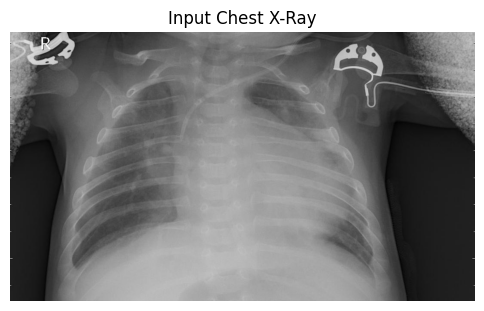

In [18]:
# UPDATE THIS PATH to your image
image_path  = r'C:\Users\DELL\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\test\PNEUMONIA\person1_virus_12.jpeg'


# Check if file exists
if not os.path.exists(image_path):
    print(f"ERROR: Image not found at {image_path}")
    print("Please update the image_path variable above.")
else:
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    print(f"Loaded image: {os.path.basename(image_path)}")
    print(f"Image tensor shape: {image_tensor.shape}")
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title('Input Chest X-Ray')
    plt.axis('off')
    plt.show()

## 7. Compute Saliency Map

This will take a minute or two depending on your hardware...

In [19]:
# Compute saliency map with different patch sizes
# Smaller patch_size = more detailed but slower
# Larger patch_size = faster but less detailed

patch_size = 16  # Try 8, 16, or 32

print(f"Computing saliency map with patch_size={patch_size}...")
saliency_map, pred_class, pred_prob = compute_saliency_map(
    model, 
    image_tensor, 
    patch_size=patch_size, 
    device=device
)

print("\n✓ Saliency map computed!")
print(f"Predicted class: {'NORMAL' if pred_class == 0 else 'PNEUMONIA'}")
print(f"Confidence: {pred_prob*100:.2f}%")

Computing saliency map with patch_size=16...


Computing saliency: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


✓ Saliency map computed!
Predicted class: PNEUMONIA
Confidence: 100.00%


## 8. Visualize Results

Saved visualization to saliency_analysis.png


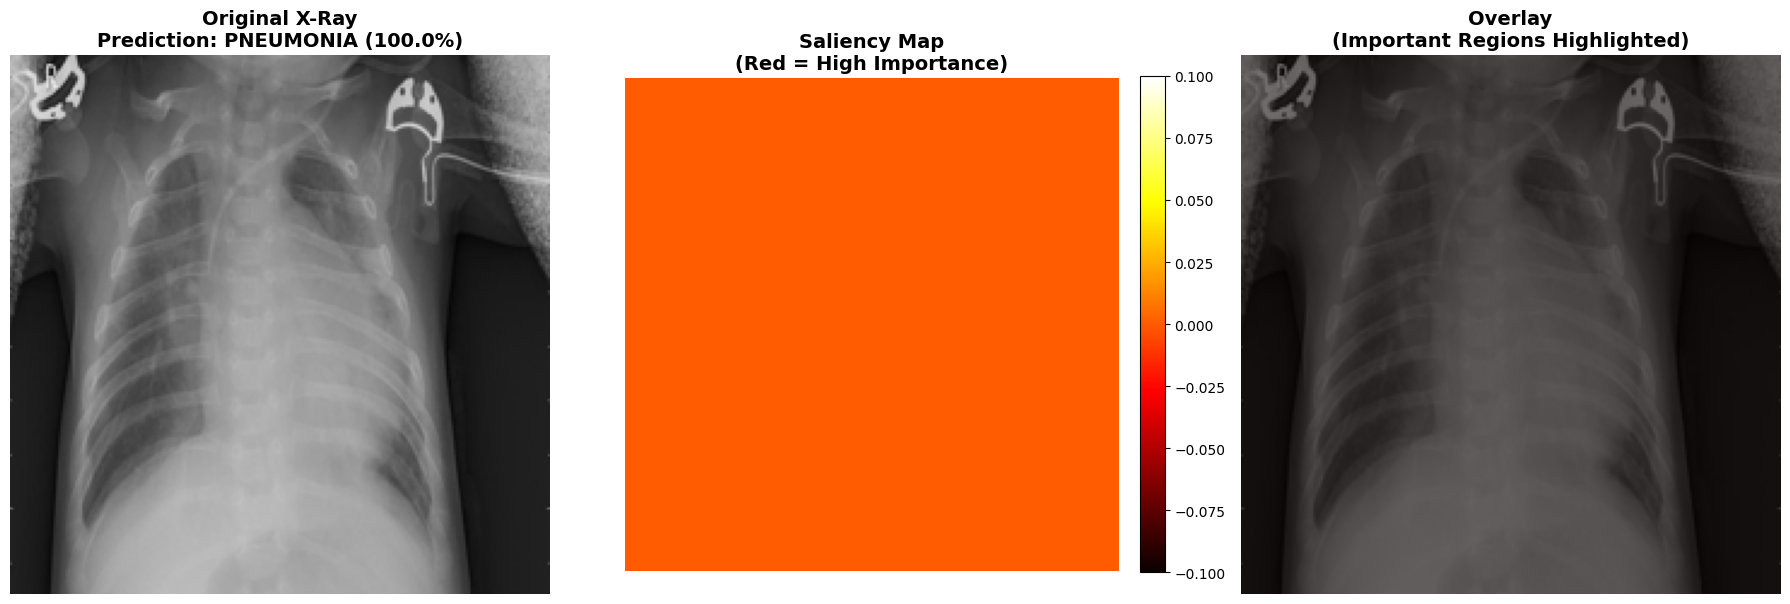

In [20]:
# Visualize the saliency map
visualize_saliency(
    image_path, 
    saliency_map, 
    pred_class, 
    pred_prob,
    save_path='saliency_analysis.png'
)

## 9. Analyze Multiple Images

Let's analyze several images from the test set.

In [21]:
import kagglehub
import glob

# Download dataset if needed
try:
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
    print(f"Dataset path: {path}")
    
    # Get some test images
    test_dir = os.path.join(path, 'chest_xray', 'test')
    
    # Get 2 normal and 2 pneumonia images
    normal_images = glob.glob(os.path.join(test_dir, 'NORMAL', '*.jpeg'))[:2]
    pneumonia_images = glob.glob(os.path.join(test_dir, 'PNEUMONIA', '*.jpeg'))[:2]
    
    test_images = normal_images + pneumonia_images
    
    print(f"\nFound {len(test_images)} test images")
    
except Exception as e:
    print(f"Could not load dataset: {e}")
    print("Please manually set test_images to a list of image paths")
    test_images = []

Dataset path: C:\Users\DELL\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2

Found 4 test images



Analyzing image 1/4: IM-0001-0001.jpeg


Computing saliency: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


Saved visualization to saliency_analysis_1.png


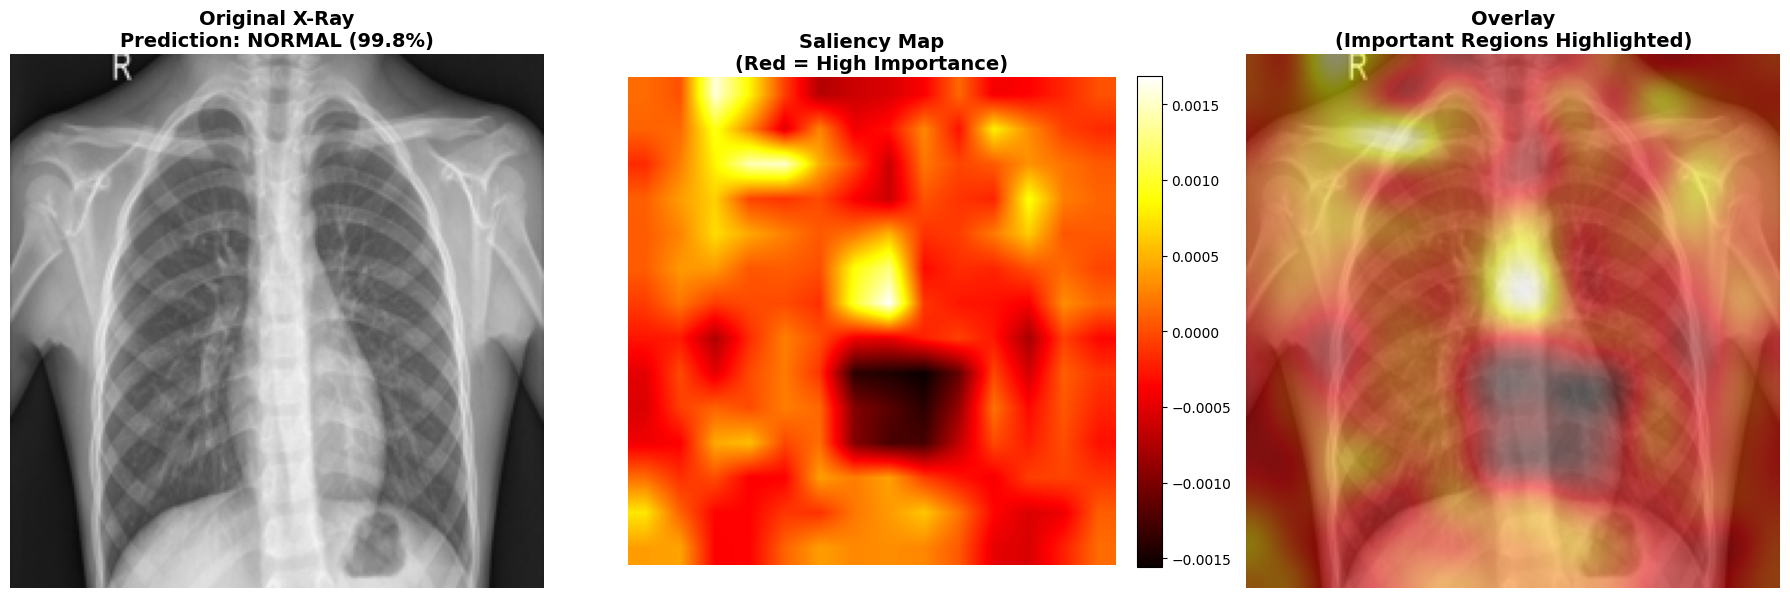


Analyzing image 2/4: IM-0003-0001.jpeg


Computing saliency: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


Saved visualization to saliency_analysis_2.png


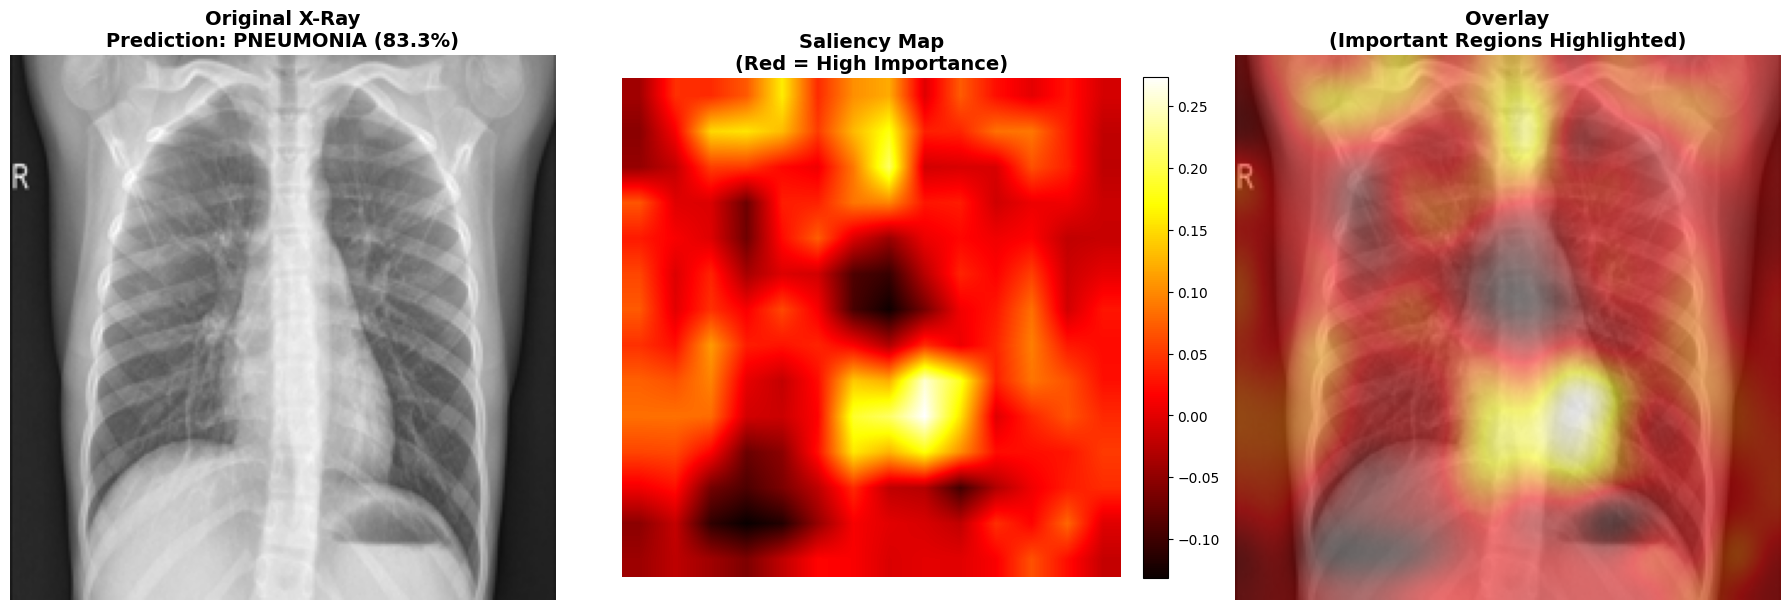


Analyzing image 3/4: person100_bacteria_475.jpeg


Computing saliency: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


Saved visualization to saliency_analysis_3.png


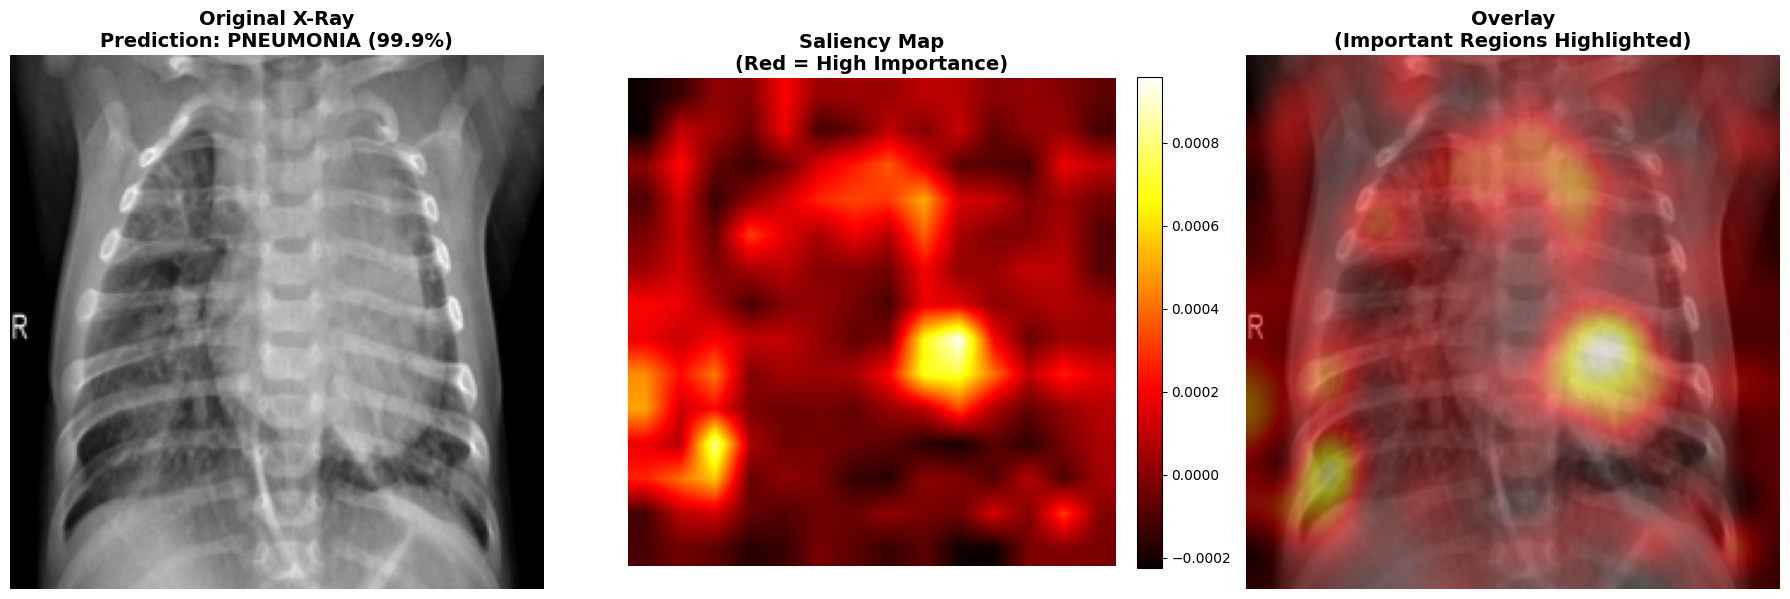


Analyzing image 4/4: person100_bacteria_477.jpeg


Computing saliency: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


Saved visualization to saliency_analysis_4.png


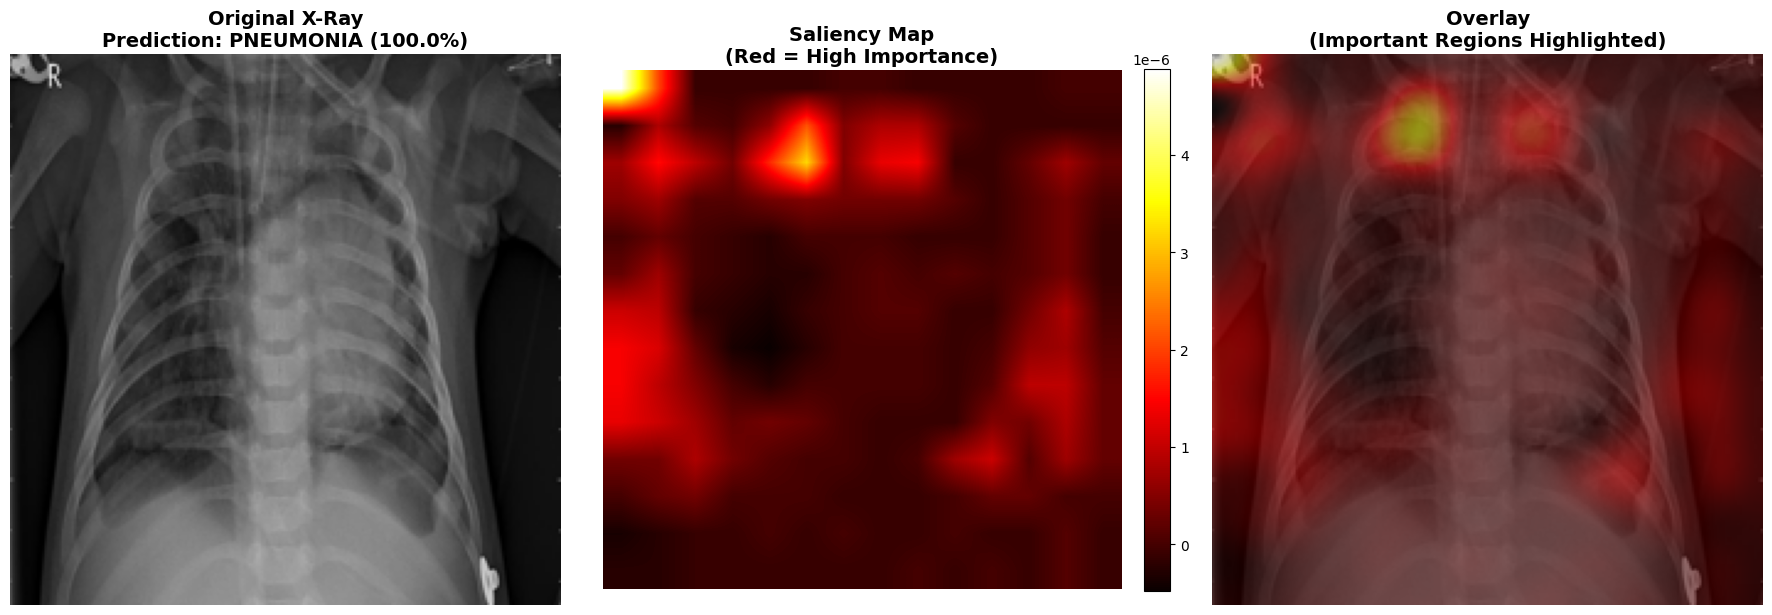

In [22]:
# Analyze each image
if len(test_images) > 0:
    for idx, img_path in enumerate(test_images):
        print(f"\n{'='*60}")
        print(f"Analyzing image {idx+1}/{len(test_images)}: {os.path.basename(img_path)}")
        print('='*60)
        
        # Load and preprocess
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)
        
        # Compute saliency
        saliency_map, pred_class, pred_prob = compute_saliency_map(
            model, image_tensor, patch_size=16, device=device
        )
        
        # Visualize
        visualize_saliency(
            img_path, 
            saliency_map, 
            pred_class, 
            pred_prob,
            save_path=f'saliency_analysis_{idx+1}.png'
        )
else:
    print("No test images to analyze. Please set up test_images list manually.")

## 10. Compare Different Patch Sizes

Computing saliency with patch_size=8...


Computing saliency: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Computing saliency with patch_size=16...


Computing saliency: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Computing saliency with patch_size=32...


Computing saliency: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


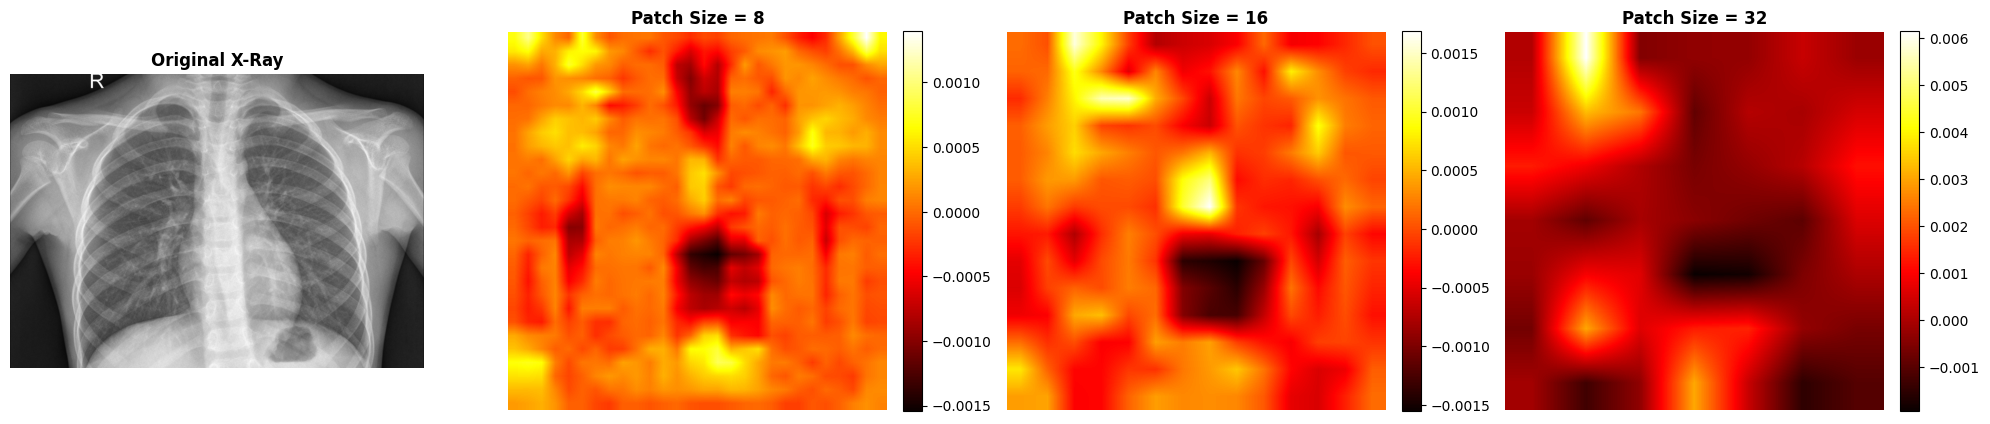


Smaller patch sizes give more detailed saliency maps but take longer to compute.


In [23]:
# Load a single test image
if len(test_images) > 0:
    test_image_path = test_images[0]
    
    image = Image.open(test_image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    
    # Try different patch sizes
    patch_sizes = [8, 16, 32]
    
    fig, axes = plt.subplots(1, len(patch_sizes)+1, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original X-Ray', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Compute and display saliency for each patch size
    for idx, ps in enumerate(patch_sizes):
        print(f"Computing saliency with patch_size={ps}...")
        saliency, pred, prob = compute_saliency_map(
            model, image_tensor, patch_size=ps, device=device
        )
        
        im = axes[idx+1].imshow(saliency, cmap='hot', interpolation='bilinear')
        axes[idx+1].set_title(f'Patch Size = {ps}', fontsize=12, fontweight='bold')
        axes[idx+1].axis('off')
        plt.colorbar(im, ax=axes[idx+1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig('patch_size_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nSmaller patch sizes give more detailed saliency maps but take longer to compute.")

## 11. Summary Statistics

In [24]:
# Analyze where the model focuses
print("Saliency Map Statistics:")
print(f"Min importance: {saliency_map.min():.4f}")
print(f"Max importance: {saliency_map.max():.4f}")
print(f"Mean importance: {saliency_map.mean():.4f}")
print(f"Std importance: {saliency_map.std():.4f}")

# Find most important regions
threshold = np.percentile(saliency_map, 90)  # Top 10% important regions
important_regions = saliency_map > threshold

print(f"\nNumber of highly important patches: {important_regions.sum()}")
print(f"Percentage of image that's highly important: {100*important_regions.sum()/important_regions.size:.1f}%")

Saliency Map Statistics:
Min importance: -0.0000
Max importance: 0.0000
Mean importance: 0.0000
Std importance: 0.0000

Number of highly important patches: 20
Percentage of image that's highly important: 10.2%


## Interpretation Guide

### How to read the saliency maps:

1. **Red/Hot regions** = Important for prediction
   - When these areas are blocked, the model's confidence drops significantly
   - The model is "looking" at these regions to make its decision

2. **Blue/Cold regions** = Less important
   - Blocking these areas doesn't affect the prediction much
   - Background or irrelevant areas

3. **For Pneumonia cases**: 
   - Look for hot spots in the lung fields
   - These often correspond to infiltrates or consolidation

4. **For Normal cases**:
   - The model might focus on overall lung clarity
   - Less concentrated hot spots

### Clinical Relevance:

- This helps radiologists understand the AI's reasoning
- Can identify if the model is focusing on artifacts or irrelevant features
- Builds trust by showing the model looks at medically relevant regions

### Limitations:

- Perturbation-based saliency is computationally expensive
- Results depend on patch size selection
- Doesn't show feature interactions
- Alternatives: Grad-CAM, Integrated Gradients, SHAP